## Import des libraries

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import pandas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from IPython.display import Image
import random

Parametres généraux

In [9]:
n_categories = 5
n_criteres = 5
n_donnees = 2500
num_epochs = 150
batchsize = 150
stiffness = 3

## Generation du dataset

In [10]:
!lincs generate classification-problem {n_criteres} {n_categories} --output-problem problem.yml
!lincs generate classification-model problem.yml --output-model model.yml
!lincs generate classified-alternatives problem.yml model.yml {n_donnees} --output-alternatives learning-set.csv

## Load le dataset

In [ ]:
# Charger les données
data = pandas.read_csv('learning-set.csv',comment="#")

#suppression de la ligne de commentaires
print(data.columns)

# Séparer les features et les labels
X = data[['Criterion '+str(i+1) for i in range(n_criteres)]].values
y = data['category'].values

Index(['name', 'Criterion 1', 'Criterion 2', 'Criterion 3', 'Criterion 4',
       'Criterion 5', 'category'],
      dtype='object')


In [ ]:

# Conversion en tensors
X_tensor = torch.FloatTensor(X)

# Convertir les catégories en entiers en utilisant LabelEncoder
label_encoder = LabelEncoder()
categories = data['category'].values
y = label_encoder.fit_transform(categories)

# Vérifier les classes associées à chaque entier
classes = label_encoder.classes_
print(f"Classes associées aux entiers : {classes}")

# Conversion en LongTensor
y_tensor = torch.LongTensor(y)

# Division des données en ensembles d'entraînement et de test
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Création des DataLoader
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)


Classes associées aux entiers : ['Best category' 'Intermediate category 1' 'Intermediate category 2'
 'Intermediate category 3' 'Worst category']


## Modele


In [ ]:

# Construction du modèle
class SimpleClassifier(nn.Module):
    def __init__(self):
        super(SimpleClassifier, self).__init__()
        self.sigm = nn.Sigmoid()
        self.biaises = nn.Parameter(torch.rand(n_criteres,n_categories-1))
        self.weights = nn.Parameter(torch.rand(n_criteres))
        self.limit = nn.Parameter(torch.rand(1))

    def forward(self, x):
        #assure que les params sont positifs
        self.limit.data = F.relu(self.limit.data)
        self.weights.data = F.relu(self.weights.data)
        self.biaises.data = F.relu(self.biaises.data)
        # Appliquer la fonction sigmoid sur (w_i + x_i) pour chaque élément
        sigmoid_outputs = self.sigm((x.unsqueeze(2).repeat(1, 1, n_categories-1) - self.biaises)*stiffness) * self.weights.unsqueeze(1).repeat(1,n_categories-1)

        # Calculer la somme pondérée pour chaque exemple dans le batch
        weighted_sum = torch.sum(sigmoid_outputs, dim=1)

        # Produire le tenseur colonne avec les 1 et 0 pour chaque exemple dans le batch
        output = self.sigm(weighted_sum-self.limit.expand(weighted_sum.size()))
        return output



# Boucle d'entrainement

Accuracy sur l'ensemble de test: 0.7725000083446503


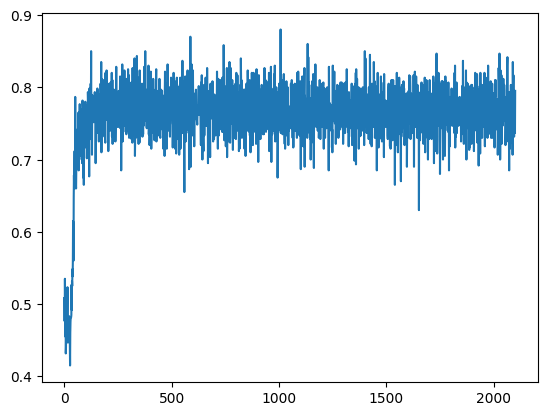

Accuracy sur l'ensemble de test: 0.7725000083446503


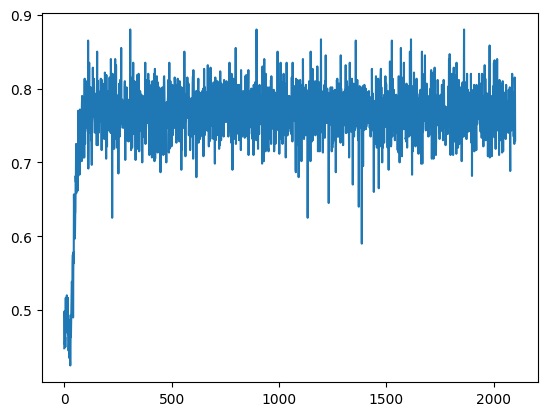

Accuracy sur l'ensemble de test: 0.7725000083446503


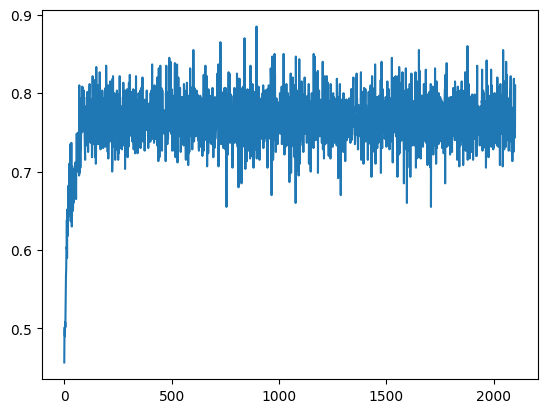

Accuracy sur l'ensemble de test: 0.7725000083446503


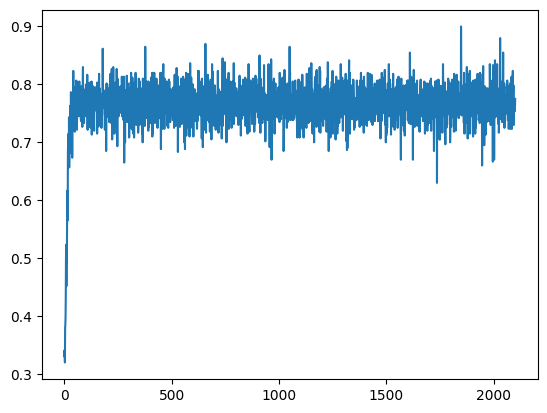

Accuracy sur l'ensemble de test: 0.7725000083446503


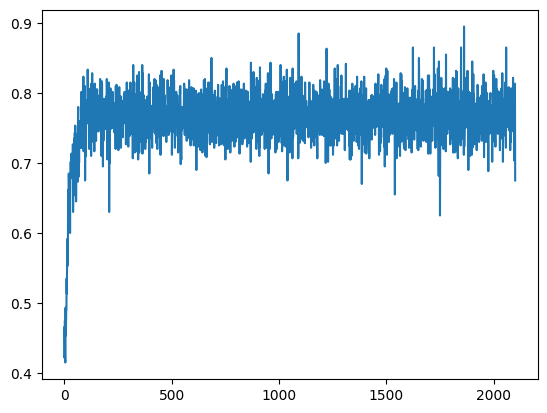

IndexError: list index out of range

In [ ]:
n_inits = 5
models = []
accuracies = []

for i in range(n_inits):
    #initialisations
    model = SimpleClassifier()
    # Définition de la fonction de perte et de l'optimiseur
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=int(num_epochs*0.05), gamma=0.2)


    # Entraînement du modèle
    accuracies = []
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # Construction de l'étiquette correspondante pour chaque exemple
            labels_onehot = torch.zeros((len(labels), n_categories-1))
            for i in range(len(labels)):
                labels_onehot[i, :labels[i]+1] = 1
        
            loss = criterion(outputs, labels_onehot)
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()  # Thresholding at 0.5
        
            accuracies.append((predicted == labels_onehot).float().mean().item())

            #modification des param d'apprentissage
        if epoch>num_epochs*0.3:
            if accuracies[-1]>0.7:
                stiffness=max(stiffness,8)
        if epoch>num_epochs*0.5:
            if accuracies[-1]>0.9:
                stiffness=max(stiffness,100)
        scheduler.step()



    # Évaluation du modèle
    correct = []
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Thresholding at 0.5
            # Construction de l'étiquette correspondante pour chaque exemple
            labels_onehot = torch.zeros((len(labels), n_categories-1))
            for i in range(len(labels)):
                labels_onehot[i, :labels[i]+1] = 1
        
            total += 1
            correct.append((predicted == labels_onehot).float().mean().item())

    accuracy = sum(correct) / total
    print(f'Accuracy sur l\'ensemble de test: {accuracy}')

    plt.figure()
    plt.plot([i for i in range(len(accuracies))], accuracies)
    plt.show()

    #tri des modeles
    models.append(model)
    accuracies.append(accuracy)

index_final = accuracies.index(max(accuracies))
model_final = models[index_final]

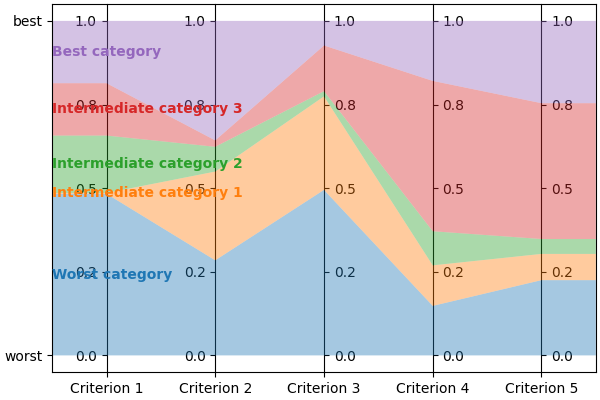

In [ ]:
!del -f model.png
!lincs visualize classification-model problem.yml model.yml model.png
Image('model.png')

In [ ]:
print(model.weights)
print(model.biaises)
print(model.limit)

Parameter containing:
tensor([0.0000, 2.1330, 1.3808, 2.0858, 0.0000], requires_grad=True)
Parameter containing:
tensor([[0.0000, 0.5401, 1.0699, 0.5218],
        [0.0000, 1.1810, 1.1049, 1.0982],
        [0.0000, 1.0899, 1.0946, 1.1019],
        [0.0000, 1.1441, 1.1133, 1.1615],
        [0.0000, 0.6064, 1.0820, 0.4886]], requires_grad=True)
Parameter containing:
tensor([1.1628], requires_grad=True)
